In [1]:
"""import packages"""
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import functools

import tensorflow as tf
from tensorflow import keras

import xlrd
from scipy.io import loadmat
import pandas as pd

In [2]:
"""load data files"""
matFile = loadmat('Pappas_Pulsed_pl200_ge_start800_int1us_1kAvg_multishot_3_mag.mat')
Data = matFile['Data']

vS1File = pd.read_excel('vS1.xlsx', sheet_name='vS1')

In [3]:
"""access columns of VS1 in data set"""
df = pd.DataFrame(vS1File)
vS1_list1 = df.columns.tolist()

"""divide VS1 data into x0 (|g>) and x1 (|e>)"""
x0 = []
x1 = []
for i in list(range(0,6700)):
    x0.append(np.float(vS1_list1[i]))
for i in list(range(6700,13400)):
    x1.append(np.float(vS1_list1[i]))

In [4]:
"""access cY data and make accessible to plot by pyplot"""
cY_list1 = []
for sublist in Data['cY']:
    for item in sublist:
        cY_list1.append(item)

cY_arr = np.array(cY_list1)
cY_list2 = cY_arr.tolist()
        
cY_list3 = []
for sublist in cY_list2:
    for item in sublist:
        cY_list3.append(item)
        
cY_list4 = []
for sublist in cY_list3:
    for item in sublist:
        cY_list4.append(item)
        
cY_list5 = []
for sublist in cY_list4:
    for item in sublist:
        cY_list5.append(item)
        
cY_list6 = []
for sublist in cY_list5:
    for item in sublist:
        cY_list6.append(np.complex(item))

In [5]:
"""append mag, phase, I, Q data into numpy arrays"""
mag0 = []
mag1 = []
phase0 = []
phase1 = []
I0 = []
I1 = []
Q0 = []
Q1 = []

x0_avg = []
mag0_avg = []
phase0_avg = []
I0_avg = []
Q0_avg = []

x1_avg = []
mag1_avg = []
phase1_avg = []
I1_avg = []
Q1_avg = []

for i in range(6700):
    mag0.append(abs(cY_list6[i]))
    phase0.append(np.angle(cY_list6[i]))
    I0.append(np.real(cY_list6[i]))
    Q0.append(np.imag(cY_list6[i]))
    
for j in list(range(0,6700,100)):
    x0_avg.append(np.mean(x0[j]))
    mag0_avg.append(np.mean(mag0[j]))
    phase0_avg.append(np.mean(phase0[j]))
    I0_avg.append(np.mean(I0[j]))
    Q0_avg.append(np.mean(Q0[j]))
    
for i in list(range(6700,13400)):
    mag1.append(abs(cY_list6[i]))
    phase1.append(np.angle(cY_list6[i]))
    I1.append(np.real(cY_list6[i]))
    Q1.append(np.imag(cY_list6[i]))
    
for j in list(range(0,6700,100)):
    x1_avg.append(np.mean(x1[j]))
    mag1_avg.append(np.mean(mag1[j]))
    phase1_avg.append(np.mean(phase1[j]))
    I1_avg.append(np.mean(I1[j]))
    Q1_avg.append(np.mean(Q1[j]))  

In [6]:
"""consolidate the S_{2,1} of the readout resonator"""
i_readout0 = []
i_readout1 = []

I0_readout = []
I1_readout = []
Q0_readout = []
Q1_readout = []

for i in list(range(0,6700)):
    
    if mag0[i]<=0.0001590 and mag0[i]>=0.0001588:
        i_readout0.append(i)
        
for i in list(range(0,6700)):
    
    if mag1[i]<=0.0007600 and mag1[i]>=0.0007598:
        i_readout1.append(i)
        
for i in list(range(0,1000)):
        
    I0_readout.append(np.real(cY_list6[i]))
    Q0_readout.append(np.imag(cY_list6[i]))
        
for i in list(range(6700+i_readout1[0]-500,6700+i_readout1[0]+500)):
    
    I1_readout.append(np.real(cY_list6[i]))
    Q1_readout.append(np.imag(cY_list6[i]))

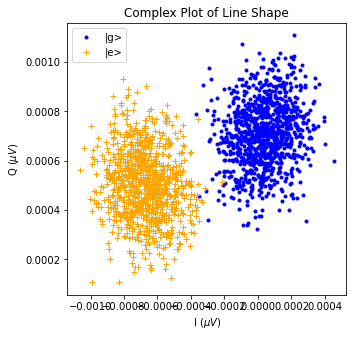

In [7]:
"""plot IQ plot for S_{2,1}"""
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(I0_readout,Q0_readout,'b.',label='|g>')
ax.plot(I1_readout,Q1_readout,'+',color='orange',label='|e>')

plt.title('Complex Plot of Line Shape')
plt.xlabel('I ($\mu V$)')
plt.ylabel('Q ($\mu V$)')
plt.legend()

In [8]:
"""the following cells are adapted from the following tutorial: https://www.youtube.com/watch?v=NMPufa4IA3A"""
"""linear svm to find line of best fit for classifying ground and excited states"""
sess = tf.compat.v1.Session()

x_vals = np.real(cY_list6)
y_vals = np.imag(cY_list6)

In [9]:
train_indices = np.random.choice(len(x_vals),
                                round(len(x_vals)*0.8),
                                replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

In [10]:
tf.compat.v1.disable_eager_execution()

batch_size = 100
x_data = tf.compat.v1.placeholder(shape=[None,2],dtype=tf.float32)
y_target = tf.compat.v1.placeholder(shape=[None,1],dtype=tf.float32)
A = tf.Variable(tf.compat.v1.random_normal(shape=[2,1]))
b = tf.Variable(tf.compat.v1.random_normal(shape=[1,1]))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [11]:
model_output = tf.subtract(tf.matmul(x_data,A),b)

In [12]:
l2_norm = tf.reduce_sum(tf.square(A))
alpha = tf.constant([0.01])
classification_term = tf.reduce_mean(tf.maximum(0.,tf.subtract(1.,tf.multiply(model_output,y_target))))
loss = tf.add(classification_term,tf.multiply(alpha,l2_norm))

In [13]:
prediction = tf.sign(model_output)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction,y_target),tf.float32))

In [14]:
my_opt = tf.compat.v1.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)
init = tf.compat.v1.global_variables_initializer()
sess.run(init)

In [15]:
loss_vec = []
train_accuracy = []
test_accuracy = []
for i in range(5000):
    rand_index = np.random.choice(len(x_vals_train),size=batch_size)
    rand_x = x_vals_train[rand_index].reshape(50,2)
    rand_y = np.transpose([y_vals_train[rand_index[:50]]]).reshape(50,1)
    sess.run(train_step,feed_dict={x_data: rand_x, y_target: rand_y})
    
    temp_loss = sess.run(loss,feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    
    train_acc_temp = sess.run(accuracy,feed_dict={
        x_data: x_vals_train.reshape(5360,2),
        y_target: np.transpose([y_vals_train[:5360]]).reshape(5360,1)
    })
    train_accuracy.append(train_acc_temp)
    
    test_acc_temp = sess.run(accuracy, feed_dict={
        x_data: x_vals_test.reshape(1340,2),
        y_target:np.transpose([y_vals_test[:1340]]).reshape(1340,1)
    })
    test_accuracy.append(test_acc_temp)
    
    if (i+1)%100 == 0:
        print('Step #{} A = {}, b = {}'.format(
             str(i+1),
             str(sess.run(A)),
             str(sess.run(b))
        ))
        print('Loss = ' + str(temp_loss))

Step #100 A = [[-0.98683137]
 [ 0.09708147]], b = [[-0.02131155]]
Loss = [1.0098206]
Step #200 A = [[-0.96728903]
 [ 0.0951588 ]], b = [[-0.02185209]]
Loss = [1.0094342]
Step #300 A = [[-0.9481336 ]
 [ 0.09327417]], b = [[-0.02239314]]
Loss = [1.0090647]
Step #400 A = [[-0.9293576 ]
 [ 0.09142686]], b = [[-0.02293382]]
Loss = [1.0087094]
Step #500 A = [[-0.9109535 ]
 [ 0.08961614]], b = [[-0.02348234]]
Loss = [1.008364]
Step #600 A = [[-0.89291376]
 [ 0.08784128]], b = [[-0.02402339]]
Loss = [1.0080365]
Step #700 A = [[-0.8752312 ]
 [ 0.08610157]], b = [[-0.0245673]]
Loss = [1.0077212]
Step #800 A = [[-0.8578989 ]
 [ 0.08439635]], b = [[-0.02511465]]
Loss = [1.007417]
Step #900 A = [[-0.8409097 ]
 [ 0.08272487]], b = [[-0.02564908]]
Loss = [1.0071274]
Step #1000 A = [[-0.8242572 ]
 [ 0.08108651]], b = [[-0.02618678]]
Loss = [1.0068474]
Step #1100 A = [[-0.80793434]
 [ 0.0794806 ]], b = [[-0.02673511]]
Loss = [1.0065739]
Step #1200 A = [[-0.7919347 ]
 [ 0.07790647]], b = [[-0.02728282]]

In [16]:
[[a1],[a2]] = sess.run(A)
[[b]] = sess.run(b)
slope = -a2/a1
y_intercept = b/a1
best_fit = []
for i in x_vals:
    best_fit.append(slope*i+y_intercept)

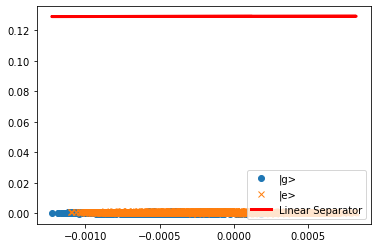

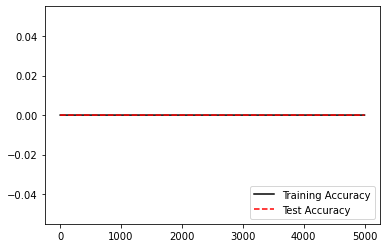

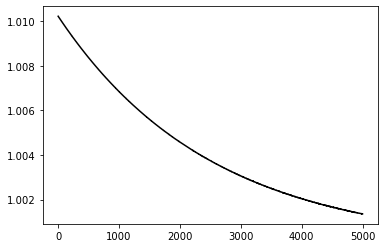

In [17]:
"""plot IQ plot with line of best fit"""
%matplotlib inline
plt.plot(I0,Q0,'o',label='|g>')
plt.plot(I1,Q1,'x',label='|e>')
plt.plot(x_vals,best_fit,'r-',label='Linear Separator',linewidth=3)
plt.legend(loc='lower right')
plt.show()

plt.plot(train_accuracy,'k-',label='Training Accuracy')
plt.plot(test_accuracy,'r--',label='Test Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(loss_vec,'k-')